# **Transfer Learning**
## Image Processing and Computer Vision - Lab Session No. 5

Contacts:

- Prof. Giuseppe Lisanti -> giuseppe.lisanti@unibo.it
- Prof. Samuele Salti -> samuele.salti@unibo.it
- Alex Costanzino -> alex.costanzino@unibo.it
- Francesco Ballerini -> francesco.ballerini4@unibo.it

# A definition of Transfer Learning
**Transfer learning** is the process of taking features learned for one task and reusing them to solve a new but similar problem, instead of starting the learning process from scratch. This technique is very popular, since it allows to build accurate models without having to train the network for a very long time. Usually, transfer learning is the way to go in tasks where the training dataset has a small number of samples.

In this lab session, you are going to see a transfer learning solution for image classification problems.




A typical CNN-based image classifier has two parts:
* **Features extractor**: a sandwich of convolutional, BN, and pooling layers which is used to extract features from the pixels of the image;
* **Classifier**: a stack of fully connected layers which assigns a class score to the image based on the features produced by the feature extractor.



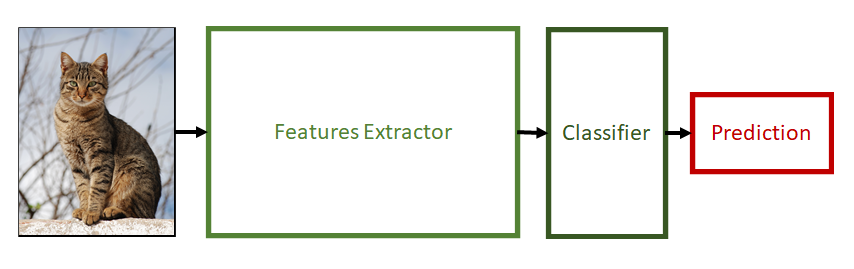

A transfer learning workflow for image classification includes the following steps:

1. **Take a pre-trained model**: choose a model that was trained on a large dataset to solve a similar problem. A common practice is to grab models from the literature, such as VGG, ResNet, MobileNet, etc.;
2. **Chop the classifier**: remove the old classifier;
3. **Add a new classifier**: adapt the architecture to solve the new task;
4. **Use the convolutional block as Feature Extractor**: train **only** the new classifier on the new dataset and exclude the feature extractor from the back-propagation process (freezing);
5. **Fine-tuning**: a last optional step involves the **fine-tuning** of the new network. It consists in unfreezing parts of the pre-trained model and continue training it on the new dataset in order to adapt the pretrained features to the new data. To avoid overfitting, we usually run this step only if the new dataset is **large**.

# Import dependencies



In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
!pip install -q wandb # weights and biases
!pip install -q torchmetrics

In [12]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import random
import requests
import shutil
import tarfile
import torch
import torch.nn as nn
import torch.nn.functional as F

from collections import defaultdict
#from google.colab import drive
from pathlib import Path
from PIL import Image
from tqdm.notebook import tqdm
from typing import Any, Callable, Dict, List, Optional

from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from torchmetrics.classification.accuracy import Accuracy
from torchinfo import summary
from torchvision import transforms as T
from torchvision.datasets import ImageFolder
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights, resnet18, ResNet18_Weights

In [13]:
import wandb

WANDB_USER = "alessandro-gentili001"  # insert your wandb username here
WANDB_PROJECT = "IPCV"

# Reproducibility

In [14]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_random(seed=42)

# Runtime settings


In [15]:
device = "cpu"
if torch.cuda.is_available():
  print("All good, a GPU is available")
  device = torch.device("cuda:0")
else:
  print("Please set GPU via Edit -> Notebook Settings")

All good, a GPU is available


# Hyperparameters

In [16]:
cfg = {
    "resize_size": 256,
    "crop_size": 224,

    "batch_size": 4,
    "num_epochs": 20,

    "lr": 1e-3,
    "wd": 1e-4,
    "step_size": 5
}

# Transfer Learning for Ants and Bees

In the first part of this lab session, your goal is to build a neural network that distinguishes between ants and bees.

## Ants and Bees Dataset
The **Ants & Bees** dataset is a very small subset of ImageNet. The dataset has ~120 training images and ~75 validation images for each class.

Let's download the dataset and analyze it:

In [9]:
!wget -q https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -q hymenoptera_data.zip

In [17]:
path_ds = "hymenoptera_data"
path_ds_train = Path(path_ds) / "train"
path_ds_val = Path(path_ds) / "val"

mean_image_net = [0.485, 0.456, 0.406]
std_image_net = [0.229, 0.224, 0.225]

# perform a data augmentation
data_transforms = {
    "train": T.Compose([T.RandomResizedCrop(cfg["crop_size"]), # focus on a part of the image
                        T.RandomHorizontalFlip(),
                        T.ToTensor(),
                        T.Normalize(mean_image_net, std_image_net)]),

    "val": T.Compose([T.Resize(cfg["resize_size"]),
                      T.CenterCrop(cfg["crop_size"]),
                      T.ToTensor(),
                      T.Normalize(mean_image_net, std_image_net)])
}

# store the new images
data_train = ImageFolder(path_ds_train, data_transforms["train"])
data_val = ImageFolder(path_ds_val, data_transforms["val"])

classes = data_train.classes
num_classes = len(classes)

print(f"# Train samples = {len(data_train)}")
print(f"# Val samples = {len(data_val)}")
print(f"Classes = {classes}")

# Train samples = 244
# Val samples = 153
Classes = ['ants', 'bees']


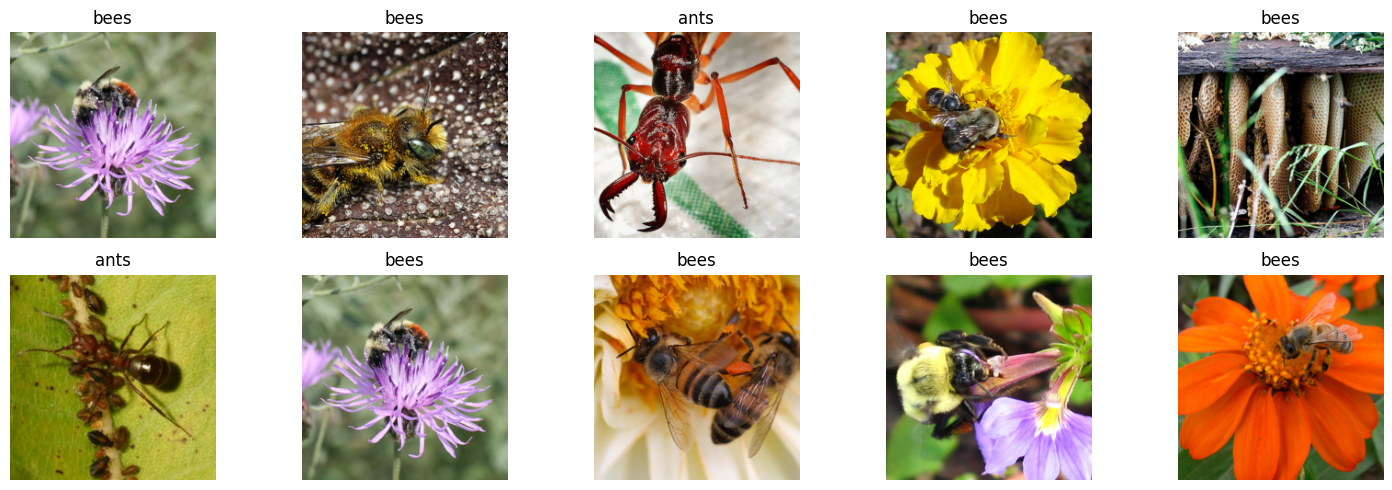

In [18]:
class NormalizeInverse(T.Normalize):
    def __init__(self, mean: List[float], std: List[float]) -> None:
        """Reconstructs the images in the input domain by inverting
        the normalization transformation.

        Args:
            mean: the mean used to normalize the images.
            std: the standard deviation used to normalize the images.
        """
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())


def show_grid(dataset: ImageFolder, process: Callable = None) -> None:
    """Shows a grid with random images taken from the dataset.

    Args:
        dataset: the dataset containing the images.
        process: a function to apply on the images before showing them.
    """
    fig = plt.figure(figsize=(15, 5))
    indices_random = np.random.randint(10, size=10, high=len(dataset))

    for count, idx in enumerate(indices_random):
        fig.add_subplot(2, 5, count + 1)
        title = dataset.classes[dataset[idx][1]]
        plt.title(title)
        image_processed = process(dataset[idx][0]) if process is not None else dataset[idx][0]
        plt.imshow(T.ToPILImage()(image_processed))
        plt.axis("off")

    plt.tight_layout()
    plt.show()


denormalize = NormalizeInverse(mean_image_net, std_image_net)
show_grid(data_val, process=denormalize)

In [19]:
loader_train = DataLoader(
    data_train,
    batch_size=cfg["batch_size"],
    shuffle=True,
    pin_memory=True
)
loader_val = DataLoader(
    data_val,
    batch_size=cfg["batch_size"],
    shuffle=False
)

## Training functionalities


In [20]:
class Trainer:
    def __init__(self,
            model: nn.Module,
            train_loader: DataLoader,
            val_loader: DataLoader,
            device: torch.device,
            num_classes: int
        ) -> None:
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.num_classes = num_classes
        self.num_epochs = cfg["num_epochs"]

        self.model = model.to(device)
        self.optimizer = AdamW(self.model.parameters(), lr=cfg["lr"], weight_decay=cfg["wd"])
        num_steps = self.num_epochs * len(train_loader)
        self.scheduler = OneCycleLR(self.optimizer, cfg["lr"], total_steps=num_steps) # defines how the learning rate change during the training
                                                                                      # start with a slow learning rate and progressively grow, at the end slow again

        self.step = 0
        self.best_acc = 0.0

        wandb.init(name=cfg["run_name"],
                   #entity=WANDB_USER, # do not insert name, it will automatically adapt the name format 
                   project=WANDB_PROJECT, config=cfg)
        self.ckpt_path = Path("ckpts")
        self.ckpt_path.mkdir(exist_ok=True)

    def logfn(self, values: Dict[str, Any]) -> None:
        wandb.log(values, step=self.step, commit=False)

    def train(self) -> None:
        for _ in tqdm(range(self.num_epochs), desc="Epoch"):
            self.model.train()

            for imgs, labels in self.train_loader:
                imgs = imgs.to(self.device)
                labels = labels.to(self.device)

                pred = self.model(imgs)
                loss = F.cross_entropy(pred, labels)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                self.scheduler.step()

                if self.step % 10 == 0:
                    self.logfn({"train/loss": loss.item()})
                    self.logfn({"train/lr": self.scheduler.get_last_lr()[0]})

                self.step += 1

            self.eval("train")
            self.eval("val")

        wandb.finish()

    @torch.no_grad()
    def eval(self, split: str) -> None:
        self.model.eval()

        loader = self.train_loader if split == "train" else self.val_loader
        acc = Accuracy("multiclass", num_classes=self.num_classes).to(self.device)

        losses = []
        for imgs, labels in loader:
            imgs = imgs.to(self.device)
            labels = labels.to(self.device)

            pred = self.model(imgs)
            loss = F.cross_entropy(pred, labels)
            losses.append(loss.item())

            pred_softmax = F.softmax(pred, dim=-1)
            acc(pred_softmax, labels)

        loss = sum(losses) / len(losses)
        accuracy = acc.compute()

        self.logfn({f"{split}/loss": loss})
        self.logfn({f"{split}/acc": accuracy})

        if accuracy > self.best_acc and split == "val":
            self.best_acc = accuracy
            torch.save(self.model.state_dict(), self.ckpt_path / f"{wandb.run.name}.pt")
            self.best_model = copy.deepcopy(self.model)

## Train the network from scratch

To build our classifier, we can use one of the off-the-shelf models provided by PyTorch. In this case, we will rely on [ResNet-18](https://arxiv.org/abs/1512.03385), and we will start by training the network from scratch.

In [22]:
net_from_scratch = resnet18(weights=None, # random initialization
                            num_classes=num_classes).to(device)

summary(
    net_from_scratch,
    input_size=(1, 3, cfg["crop_size"], cfg["crop_size"])  # Include batch size as the first dimension
)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 2]                    --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│

In [23]:
cfg["run_name"] = "resnet_from_scratch"

trainer = Trainer(
    net_from_scratch,
    loader_train,
    loader_val,
    device,
    num_classes
)
trainer.train()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

train/acc,▁▁▃▃▂▃▃▂▅▇▄▆▇▆▆██▇▇▇
train/loss,▃▄▃▆▄▅▃▃▅▁█▄▄▂▃▄▂▂▄▄▃▂▃▂▂▂▂▃▃▂▁▃▂▂▂▃▄▂▂▂
train/lr,▁▁▂▂▃▄▅▅▆▇███████▇▇▇▇▆▆▆▅▅▄▄▄▃▃▂▂▂▂▁▁▁▁▁
val/acc,▁▂▃▅▄▄▃▄▄▃▃▅█▄██▆▇▆▆
val/loss,▂▄▁▁█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train/acc,0.69672
train/loss,0.59718
train/lr,0.0
val/acc,0.66013
val/loss,0.63303


In [25]:
print(f"Best val acc = {trainer.best_acc:.3f}")

Best val acc = 0.732


## Apply Transfer Learning

Due to the small size of our training dataset, the solution learned from the network is not very accurate. This is the case in which transfer learning can help us: we can use the feature extractor trained on the ImageNet dataset as a plug-and-play module and add a new classifier on top of it. In the picture below we recap the architecture of ResNet-18:

<img src = "https://forums.fast.ai/uploads/default/original/3X/f/9/f9a8eaaa866c2b783162fe65afdff67171e993fb.png" width = "400px" height="400px">

Let's take a look at the PyTorch [implementation](https://github.com/pytorch/vision/blob/ab0b9a436bd64c4d0309f1b700868c2fe73c0f3e/torchvision/models/resnet.py#L166) of ResNet-18 in order to adapt the pre-trained architecture to the new task.


With the function below, we'll cover steps **1,2, and 3** of the workflow presented in the introduction:

In [26]:
def get_model(
        num_classes: int,
        weights: Optional[ResNet18_Weights] = None
    ) -> nn.Module:
    """Gets an image classifier based on ResNet-18.

    Args:
        num_classes: the number of classes.
        weights: pretrained weights to load into the network.
                 If None, the network is randomly initialized.

    Returns:
        The required network.
    """
    model = resnet18(weights=weights)
    # Here we override the old classifier
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    return model

To avoid to use the gradients with respect to some parameters of our model, we can set their `requires_grad` attribute to `False`:

In [27]:
def set_requires_grad(layer: torch.nn.Module, train: bool) -> None:
    """Sets the requires_grad attribute to True or False for each parameter within a layer.

        Args:
            layer: the layer to freeze.
            train: if true train the layer.
    """
    for p in layer.parameters():
        p.requires_grad = train

In [34]:
weights = ResNet18_Weights.IMAGENET1K_V1 # use the parameters for the backbone
net_transfer = get_model(num_classes, weights).to(device)

# train only the claddifier, the backbone remain the same
set_requires_grad(net_transfer.conv1, False)
set_requires_grad(net_transfer.bn1, False)
set_requires_grad(net_transfer.layer1, False)
set_requires_grad(net_transfer.layer2, False)
set_requires_grad(net_transfer.layer3, False)
set_requires_grad(net_transfer.layer4, False)

summary(
    net_transfer,
    input_size=(1, 3, cfg["crop_size"], cfg["crop_size"])  # Include batch size as the first dimension
)


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 2]                    --
├─Conv2d: 1-1                            [1, 64, 112, 112]         (9,408)
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         (128)
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           (36,864)
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           (128)
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           (36,864)
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           (128)
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]   

In [35]:
cfg["run_name"] = "resnet_transfer"

trainer = Trainer(
    net_transfer,
    loader_train,
    loader_val,
    device,
    num_classes
)
trainer.train()

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

train/acc,▁▃▅▆▅▆▇▇▇█▆▇███▇████
train/loss,▄▄▃▄▄▃▃▃▂▃▂▃▂▄▂▂▁█▂▂▂▄▂▄▁▂▁▁▂▁▂▂▂▄▂▄▂▂▃▁
train/lr,▁▁▂▂▃▄▅▅▆▇███████▇▇▇▇▆▆▆▅▅▄▄▄▃▃▂▂▂▂▁▁▁▁▁
val/acc,▁▃▅▅▅▇▇▇▇█▆▇███▇████
val/loss,█▇▅▄▄▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁
train/acc,0.95082
train/loss,0.13856
train/lr,0.0
val/acc,0.95425
val/loss,0.16984


In [36]:
print(f"Best val acc = {trainer.best_acc:.3f}")

Best val acc = 0.954




> **Good Practice**: *if you have limited amount of data, start from a pre-trained network.*



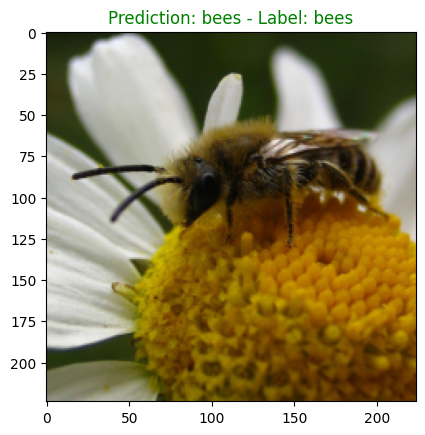

In [39]:
#@title Show Predictions {run:"auto", display-mode:"form"}
index_sample = 86  #@param {type:"slider", min:0, max:152, step:1}
image, label =  data_val[index_sample]
batch_image = image.unsqueeze(0)

net_transfer.eval()
with torch.no_grad():
    output = net_transfer(batch_image.to(device))
    _, preds = torch.max(output, 1)

fig = plt.figure()
cax = plt.imshow(T.ToPILImage()(denormalize(image)))

title = f"Prediction: {classes[preds[0].item()]} - Label: {classes[label]}"
title_obj = plt.title(title)
plt.setp(title_obj, color=("green" if preds[0]==label else "red"))

plt.show()

## Fine-tune the network

Once the classifier has been trained on the new dataset, you can try to keep on training the **whole** model end-to-end for few epochs and with a lower learning rate. A common practice is to make the initial learning rate 10 times smaller than the one used to train the network from scratch.

> **Good Practice**: *use a smaller learning rate than the one use for the scratch training*.

> **Good Practice**: *fine-tune for few epochs*.

In [40]:
sd = torch.load("ckpts/resnet_transfer.pt")
net_transfer.load_state_dict(sd)

set_requires_grad(net_transfer.conv1, True)
set_requires_grad(net_transfer.bn1, True)
set_requires_grad(net_transfer.layer1, True)
set_requires_grad(net_transfer.layer2, True)
set_requires_grad(net_transfer.layer3, True)
set_requires_grad(net_transfer.layer4, True)

/tmp/ipykernel_37/3601968838.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sd = torch.load("ckpts/resnet_transfer.pt")


Check the trainable parameters:

In [41]:
summary(
    net_transfer,
    input_size=(1, 3, cfg["crop_size"], cfg["crop_size"])  # Include batch size as the first dimension
)


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 2]                    --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│

Since the Ants and Bees dataset is small, fine-tuning the networks might not be the best idea, as there is a high risk of overfitting.

In [42]:
cfg["run_name"] = "resnet_fine_tuning"
cfg["lr"] *= 0.1
cfg["num_epochs"] = 10

trainer = Trainer(
    net_transfer,
    loader_train,
    loader_val,
    device,
    num_classes
)
trainer.train()

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

train/acc,▆▆▁▇▅▆▇█▇▇
train/loss,▂▁▂▁▂▃▂▂▂▇▅▂▃▂▂▁▂▃▁▂▂█▆▅▁▁▂▁▁▁▆▃▂▁▂▂▂▁▁▁
train/lr,▁▁▂▂▃▃▅▅▆▇███████▇▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁
val/acc,█▄▁▆▅▄▆▆▇▇
val/loss,▁▄█▂▃▃▂▁▁▁
train/acc,0.96311
train/loss,0.10727
train/lr,0.0
val/acc,0.94118
val/loss,0.17727


In [44]:
print(f"Best val acc = {trainer.best_acc:.3f}")

Best val acc = 0.954


# Now it's your turn: classify food

Using the concepts explained above, try to develop an application to classify food images from the [Food-101](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/) dataset. This dataset contains 101 food categories. In the following cells, you will find the code to download the dataset and extract a subset of 11 classes.

You can proceed by following this workflow:

1. Create the a dataset class using `torchvision.datasets.ImageFolder`;
1. Visualize some images from the dataset;
1. Create the `DataLoaders`;
1. Write a new function called `get_model_for_food` (you can take inspiration from the `get_model` function) in order to get a pre-trained [MobileNetV2](https://arxiv.org/abs/1801.04381) which can classify the 11 categories of food;
1. Train **only the classifier** of the new model. What is the accuracy reached on the validation dataset?

In [45]:
!wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz

# drive.mount("/content/drive")
# !ls -q "/content/drive/My Drive"
# !cp -q "/content/drive/My Drive/food-101.tar.gz" "food-101.tar.gz"

--2024-09-10 09:32:56--  http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz [following]
--2024-09-10 09:32:56--  https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4996278331 (4.7G) [application/x-gzip]
Saving to: 'food-101.tar.gz'

food-101.tar.gz     100%[===================>]   4.65G  35.5MB/s    in 2m 17s  

2024-09-10 09:35:14 (34.7 MB/s) - 'food-101.tar.gz' saved [4996278331/4996278331]



NameError: name 'drive' is not defined

Extract only 11 categories:

In [46]:
def get_images_from_categories(
        path_tar: str,
        path_out: str,
        categories: List[str]
    ) -> int:
    """Extracts only images belonging to some categories.

    Args:
        path_tar: path to the tar file.
        path_out: path to the output folder.
        categories: the categories to use.

    Returns:
        The number of extracted images.
    """
    num_images = 0
    tar = tarfile.open(path_tar, "r")
    for member in tqdm(tar, leave=False):
        if member.name.find("jpg") > 0:
                category = member.name.split("/")[-2]
                if category in categories:
                    tar.extract(member, path_out)
                    num_images += 1
        if member.name.find("txt") > 0:
            tar.extract(member, path_out)

    return num_images


categories = [
    "apple_pie",
    "breakfast_burrito",
    "chicken_curry",
    "creme_brulee",
    "falafel",
    "frozen_yogurt",
    "hot_and_sour_soup",
    "macarons",
    "pancakes",
    "ramen",
    "spaghetti_bolognese"
]
path_tar = "food-101.tar.gz"
num_images = get_images_from_categories(path_tar, "", categories)
print(f"{num_images} were extracted")

0it [00:00, ?it/s]

11000 were extracted


Split the image data into train and validation folders using the split files `meta/train.txt` and `meta/test.txt`:


In [47]:
def move_images(
        path_split: str,
        path_source: str,
        path_dest: str,
        categories: List[str]
    ) -> int:
    """
    Moves images from the image folder to the destination folder according to the split file.

    Args:
        path_split: the path to the text file containing the image paths.
        path_source: the path to the image folder.
        path_dest: the path to the destination folder.

    Returns:
        The number of moved images.
    """
    dict_cat_img = defaultdict(list)

    with open(path_split, "r") as f:
        paths = [read.strip() for read in f.readlines()]
        for p in paths:
            category, file_name = p.split("/")
            if category in categories:
                dict_cat_img[category].append(file_name + ".jpg")

    num_images = 0
    categories = list(dict_cat_img.keys())
    for i in tqdm(range(len(categories)), leave=False):
        category = categories[i]
        path_dest_cat = Path(path_dest) / category
        Path(path_dest_cat).mkdir(parents=True, exist_ok=True)

        for image in dict_cat_img[category]:
            if (Path(path_source) / category / image).is_file():
                shutil.copy(
                    Path(path_source) / category / image,
                    Path(path_dest) / category / image
                )
                num_images += 1

    return num_images


path_images = "food-101/images/"
path_train_split = "food-101/meta/train.txt"
path_images_train = "food-101/train"

num_images = move_images(path_train_split, path_images, path_images_train, categories)
print(f"{num_images} training images were moved")

path_val_split = "food-101/meta/test.txt"
path_images_val = "food-101/val"

num_images = move_images(path_val_split, path_images, path_images_val, categories)
print(f"{num_images} validation images were moved")

  0%|          | 0/11 [00:00<?, ?it/s]

8250 training images were moved


  0%|          | 0/11 [00:00<?, ?it/s]

2750 validation images were moved


Use the `path_images_train` and `path_images_val` variables to create the training and validation datasets. You can use the same data transformations adopted for the Ants and Bees example:



In [49]:
# ==================================================================== #
#                         YOUR CODE STARTS HERE                        #
# ==================================================================== #
from torchvision import datasets, transforms

# Data transformations similar to the Ants and Bees example
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Create the training and validation datasets
data_food_train = datasets.ImageFolder(path_images_train, transform=data_transforms['train'])
data_food_val = datasets.ImageFolder(path_images_val, transform=data_transforms['val'])

# ==================================================================== #
#                         YOUR CODE ENDS HERE                          #
# ==================================================================== #

classes_food = data_food_train.classes
num_food_classes = len(classes_food)

print(f"# Train samples = {len(data_food_train)}")
print(f"# Val samples = {len(data_food_val)}")
print(f"Classes = {classes_food}")

# Train samples = 8250
# Val samples = 2750
Classes = ['apple_pie', 'breakfast_burrito', 'chicken_curry', 'creme_brulee', 'falafel', 'frozen_yogurt', 'hot_and_sour_soup', 'macarons', 'pancakes', 'ramen', 'spaghetti_bolognese']


Before training, visualize some examples using the `show_grid` function:

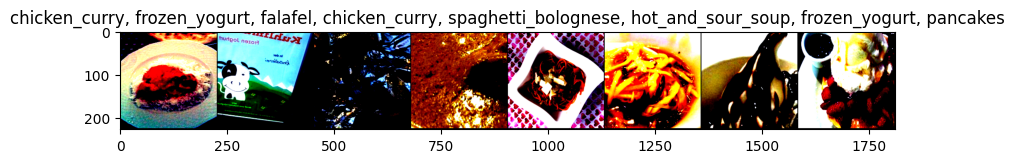

In [50]:
# ==================================================================== #
#                         YOUR CODE STARTS HERE                        #
# ==================================================================== #

import matplotlib.pyplot as plt
import torchvision.utils

# Function to display a grid of images
def show_grid(images, labels, classes):
    plt.figure(figsize=(10, 10))
    grid_img = torchvision.utils.make_grid(images, nrow=8)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.title(", ".join([classes[label] for label in labels]))
    plt.show()

# Load a batch of training data to visualize
data_loader = torch.utils.data.DataLoader(data_food_train, batch_size=8, shuffle=True)
images, labels = next(iter(data_loader))

# Show the grid of images
show_grid(images, labels, classes_food)

# ==================================================================== #
#                         YOUR CODE ENDS HERE                          #
# ==================================================================== #

Create the `DataLoaders`:

In [51]:
cfg["batch_size"] = 128

# ==================================================================== #
#                         YOUR CODE STARTS HERE                        #
# ==================================================================== #

from torch.utils.data import DataLoader

# Create the DataLoaders
train_loader = DataLoader(data_food_train, batch_size=cfg["batch_size"], shuffle=True, num_workers=4)
val_loader = DataLoader(data_food_val, batch_size=cfg["batch_size"], shuffle=False, num_workers=4)

# Check DataLoader sizes
print(f"Train Loader Size: {len(train_loader)} batches")
print(f"Val Loader Size: {len(val_loader)} batches")

# ==================================================================== #
#                         YOUR CODE ENDS HERE                          #
# ==================================================================== #

Train Loader Size: 65 batches
Val Loader Size: 22 batches


Write a function to get a feature extractor + classifier based on [MobileNetV2](https://github.com/pytorch/vision/blob/ab0b9a436bd64c4d0309f1b700868c2fe73c0f3e/torchvision/models/mobilenetv2.py#L67):



In [52]:
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
import torch.nn as nn

def get_model_for_food(
        num_classes: int,
        weights: Optional[MobileNet_V2_Weights] = None
    ) -> nn.Module:
    """Gets an image classifier based on MobileNet V2.

    Args:
        num_classes: the number of classes.
        weights: pretrained weights to load into the network.
                 If None, the network is randomly initialized.

    Returns:
        The required network.
    """
    # ==================================================================== #
    #                         YOUR CODE STARTS HERE                        #
    # ==================================================================== #
    
    # Load MobileNetV2 with or without pretrained weights
    if weights is not None:
        model = mobilenet_v2(weights=weights)
    else:
        model = mobilenet_v2(weights=None)

    # Replace the classifier with a new one for the specific number of classes
    # MobileNetV2's classifier is a Sequential with [Dropout, Linear]
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

    return model

    # ==================================================================== #
    #                         YOUR CODE ENDS HERE                          #
    # ==================================================================== #

weights = MobileNet_V2_Weights.IMAGENET1K_V1
net_food = get_model_for_food(num_food_classes, weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 105MB/s] 


Use `set_requires_grad` to freeze the feature extractor of MobileNetV2. Is the number of trainable parameters correct?

In [53]:
# ==================================================================== #
#                         YOUR CODE STARTS HERE                        #
# ==================================================================== #

def set_requires_grad(model, feature_extracting):
    """Sets the requires_grad attribute of the parameters to False 
    for freezing the feature extractor layers.

    Args:
        model: the neural network model.
        feature_extracting: if True, freeze the feature extractor.
    """
    if feature_extracting:
        for param in model.features.parameters():
            param.requires_grad = False

# Freeze the feature extractor of MobileNetV2
set_requires_grad(net_food, feature_extracting=True)

# Check the number of trainable parameters
trainable_params = sum(p.numel() for p in net_food.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in net_food.parameters())

print(f"Trainable parameters: {trainable_params}")
print(f"Total parameters: {total_params}")

# ==================================================================== #
#                         YOUR CODE ENDS HERE                          #
# ==================================================================== #

Trainable parameters: 14091
Total parameters: 2237963


Train the model:

In [54]:
cfg["run_name"] = "mobilenet_transfer"
cfg["lr"] = 1e-3
cfg["num_epochs"] = 8

# ==================================================================== #
#                         YOUR CODE STARTS HERE                        #
# ==================================================================== #

import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn as nn
import time

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Only pass the classifier parameters to the optimizer, as the feature extractor is frozen
optimizer = optim.Adam(net_food.classifier.parameters(), lr=cfg["lr"])

# Learning rate scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training the model
def train_model(model, criterion, optimizer, scheduler, num_epochs, dataloaders, dataset_sizes, device):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('-' * 10)
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Training the model
dataloaders = {
    'train': train_loader,
    'val': val_loader
}
dataset_sizes = {
    'train': len(train_loader.dataset),
    'val': len(val_loader.dataset)
}

# Call the training function
net_food = train_model(
    net_food,
    criterion,
    optimizer,
    scheduler,
    num_epochs=cfg["num_epochs"],
    dataloaders=dataloaders,
    dataset_sizes=dataset_sizes,
    device=device
)

# ==================================================================== #
#                         YOUR CODE ENDS HERE                          #
# ==================================================================== #

Epoch 1/8
----------
train Loss: 1.4827 Acc: 0.5581
val Loss: 0.7461 Acc: 0.8047
Epoch 2/8
----------
train Loss: 0.9266 Acc: 0.7176
val Loss: 0.5855 Acc: 0.8273
Epoch 3/8
----------
train Loss: 0.8367 Acc: 0.7361
val Loss: 0.5161 Acc: 0.8425
Epoch 4/8
----------
train Loss: 0.7865 Acc: 0.7493
val Loss: 0.5032 Acc: 0.8396
Epoch 5/8
----------
train Loss: 0.7724 Acc: 0.7503
val Loss: 0.4753 Acc: 0.8473
Epoch 6/8
----------
train Loss: 0.7313 Acc: 0.7595
val Loss: 0.4514 Acc: 0.8527
Epoch 7/8
----------
train Loss: 0.7208 Acc: 0.7709
val Loss: 0.4479 Acc: 0.8615
Epoch 8/8
----------
train Loss: 0.6886 Acc: 0.7800
val Loss: 0.4249 Acc: 0.8622
Training complete in 3m 8s
Best val Acc: 0.8622


In [55]:
print(f"Best val acc = {trainer.best_acc:.3f}")

Best val acc = 0.954


Finally, classify an image from the web:

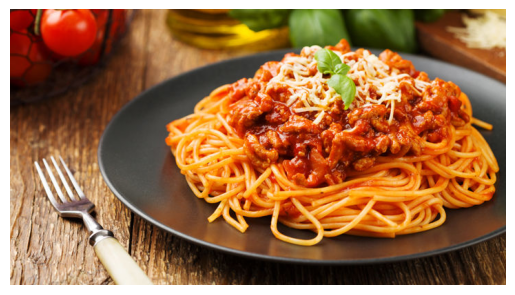

Predicted class = spaghetti_bolognese


In [56]:
image_url = "https://supervalu.ie/thumbnail/720x400/var/files/real-food/recipes/Uploaded-2020/spaghetti-bolognese-recipe.jpg?fill=1"
response = requests.get(image_url, stream=True)

image = Image.open(response.raw)
plt.imshow(image)
plt.axis("off")
plt.show()

image = data_transforms["val"](image)
image = image.unsqueeze(0).to(device)

net_food.eval()
with torch.no_grad():
    net_output = net_food(image)
    pred = torch.argmax(net_output, -1)

print(f"Predicted class = {classes_food[pred.item()]}")

# Try this at home

1. Instead of using only 11 categories, try to use the whole dataset to run the steps above;
1. Now that the size of dataset is much larger, try to fine-tune the network and see if it leads to higher validation accuracy;
1. Modify the `Trainer` class so that, at the end of training, the accuracy on the test set is computed for the model with the highest validation accuracy.